In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from collections import defaultdict
from tqdm import tqdm
import sys
sys.path.append('..')
from utils import ising_data_builder, H5IsingDataset



# Red Neuronal Convolucional (CNN) para Clasificación del Modelo Ising

Este notebook entrena y evalúa una CNN con arquitectura AlexNet adaptada para clasificar las fases del modelo Ising.



## Construcción del Dataset



In [3]:
# Crear el dataset
data = ising_data_builder('../data/data_10/').h5_path
dataset = H5IsingDataset(data)

## División Train/Test



In [ ]:
n = len(dataset)
labels = np.asarray(dataset.y[:]) 

# Train / Test Split estratificado
train_idx, test_idx = train_test_split(
    np.arange(n),
    test_size=0.2,
    stratify=labels,
    random_state=4
)

# Subsets que no copian datos, solo crean vistas por índices
train_set = Subset(dataset, train_idx.tolist())
test_set = Subset(dataset, test_idx.tolist())

# DataLoaders -> genera los batches
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=0)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False, num_workers=0)


## Definición del Modelo CNN



In [ ]:
# CNN con arquitectura AlexNet adaptada para 10x10
class AlexNetIsing(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()
        
        # Capas convolucionales (adaptadas para entrada 10x10)
        self.features = nn.Sequential(
            # Primera capa convolucional
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # 10x10 -> 10x10
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 10x10 -> 5x5
            
            # Segunda capa convolucional
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # 5x5 -> 5x5
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 5x5 -> 2x2
            
            # Tercera capa convolucional
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # 2x2 -> 2x2
            nn.ReLU(inplace=True),
        )
        
        # Capas fully connected
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128 * 2 * 2, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        # Asegurar que la entrada tenga la dimensión del canal
        if x.dim() == 3:  # (batch, height, width)
            x = x.unsqueeze(1)  # (batch, 1, height, width)
        
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x

# Model, loss, optimizer para CNN
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_cnn = AlexNetIsing(num_classes=1).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=1e-3)



## Entrenamiento y Evaluación


In [ ]:
# Entrenamiento
def train_epoch(model, loader):
    model.train()
    total_loss, total_correct, total = 0, 0, 0

    for X, y in loader:
        X, y = X.to(device), y.float().to(device)

        logits = model(X).squeeze()  # Forward y eliminar dimensión extra [batch, 1] -> [batch]
        loss = loss_fn(logits, y)    # Loss

        optimizer.zero_grad() # Limpiar gradientes
        loss.backward()       # Backward propagation
        optimizer.step()      # Update weights and biases

        total_loss += loss.item() * X.size(0) # Pérdida del batch

        preds = (torch.sigmoid(logits) >= 0.5).long()     # Logits a labels
        total_correct += (preds == y.long()).sum().item() # Contar correctos
        total += X.size(0) 
        
    # Pérdida promedio y accuracy
    return total_loss / total, total_correct / total 

# Evaluación
def eval_epoch(model, loader):
    model.eval()
    total_loss, total_correct, total = 0, 0, 0

    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.float().to(device)

            logits = model(X).squeeze()  # Eliminar dimensión extra [batch, 1] -> [batch]
            loss = loss_fn(logits, y)

            total_loss += loss.item() * X.size(0)
            preds = (torch.sigmoid(logits) >= 0.5).long()
            total_correct += (preds == y.long()).sum().item()
            total += X.size(0)

    return total_loss / total, total_correct / total



In [11]:
# Loop de entrenamiento
train_losses, train_accs = [], []
test_losses, test_accs = [], []

for epoch in tqdm(range(1, 6), desc="Epochs"):
    train_loss, train_acc = train_epoch(model_cnn, train_loader)
    test_loss, test_acc = eval_epoch(model_cnn, test_loader)
    
    # Guardar métricas
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)



Epochs: 100%|██████████| 5/5 [04:03<00:00, 48.62s/it]


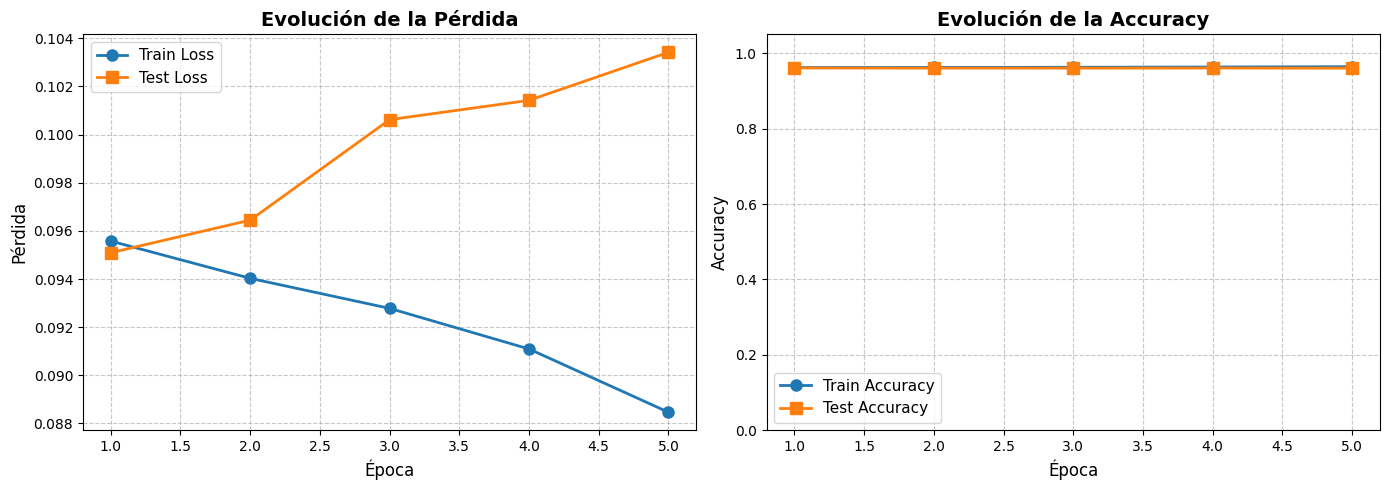

In [ ]:
# Graficar métricas de entrenamiento
epochs = range(1, len(train_losses) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de pérdida
ax1.plot(epochs, train_losses, 'o-', label='Train Loss', linewidth=2, markersize=8)
ax1.plot(epochs, test_losses, 's-', label='Test Loss', linewidth=2, markersize=8)
ax1.set_xlabel('Época', fontsize=12)
ax1.set_ylabel('Pérdida', fontsize=12)
ax1.set_title('Evolución de la Pérdida', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, linestyle='--', alpha=0.7)

# Gráfico de accuracy
ax2.plot(epochs, train_accs, 'o-', label='Train Accuracy', linewidth=2, markersize=8)
ax2.plot(epochs, test_accs, 's-', label='Test Accuracy', linewidth=2, markersize=8)
ax2.set_xlabel('Época', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('Evolución de la Accuracy', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.set_ylim([0, 1.05])

plt.tight_layout()
plt.savefig('../img_results/training_curves_cnn_gen.png', dpi=300, bbox_inches='tight')
plt.show()


## Matriz de confusión

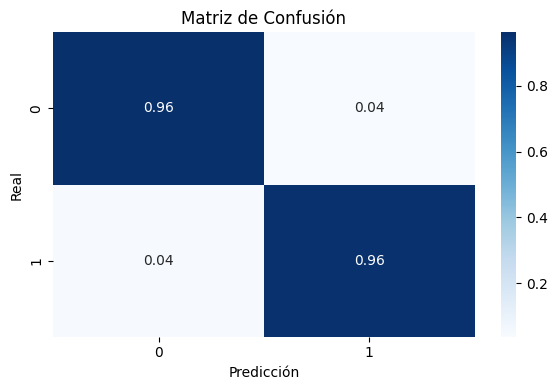

In [13]:
model_cnn.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for X, y in test_loader:
        X = X.to(device)

        logits = model_cnn(X).squeeze()  # Eliminar dimensión extra [batch, 1] -> [batch]

        # Convertir a clases 0/1
        preds = (torch.sigmoid(logits) >= 0.5).long()

        # Guardar todo
        all_preds.append(preds.cpu())
        all_labels.append(y.long().cpu())

# Convertir listas de tensores a arrays numpy concatenados
all_preds = torch.cat(all_preds).numpy() 
all_labels = torch.cat(all_labels).numpy()

# Matriz de confusión
cm = confusion_matrix(all_labels, all_preds, normalize='true')

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.tight_layout()
plt.savefig('../img_results/confusion_matrix_nn.png', dpi=300, bbox_inches='tight')
plt.show()

## Accuracy por Temperatura

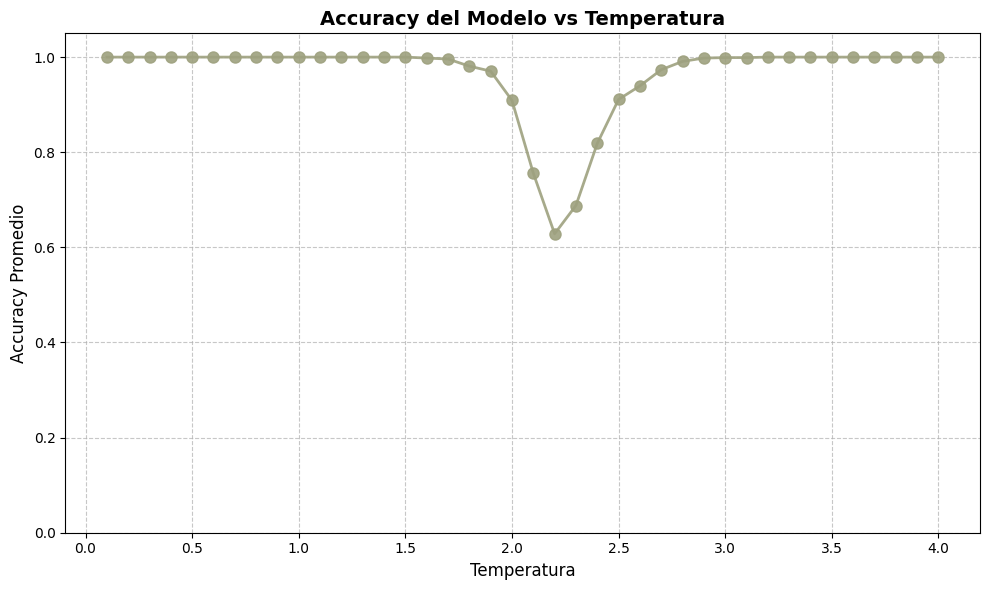

In [18]:
# Análisis de accuracy por temperatura
import os
sys.path.append('..')
from utils import read_ising_file

model_cnn.eval()
temp_data = defaultdict(lambda: {'preds': [], 'labels': []})
folder = '../data/'

# Procesar archivos y hacer predicciones por lotes
for file in os.listdir(folder):
    if 'ising_' not in file:
        continue
    
    try:
        ising = read_ising_file(folder + file)
        temp = ising.metadata['T']
        label = ising.metadata['class']
        spins = ising.load_all_spins(invert=False)
        
        # Procesar todos los espines de un archivo en un solo batch
        with torch.no_grad():
            X = torch.tensor(spins, dtype=torch.float32).to(device)
            preds = (torch.sigmoid(model_cnn(X)) >= 0.5).long().cpu().numpy()
            
            temp_data[temp]['preds'].extend(preds)
            temp_data[temp]['labels'].extend([label] * len(preds))
    except (ValueError, KeyError, IndexError):
        continue

# Calcular accuracy por temperatura
temperaturas, accuracies = [], []
for temp in sorted(temp_data.keys()):
    preds = np.array(temp_data[temp]['preds'])
    labels = np.array(temp_data[temp]['labels'])
    accuracies.append(np.mean(preds == labels))
    temperaturas.append(temp)

temperaturas, accuracies = np.array(temperaturas), np.array(accuracies)

# Graficar
plt.figure(figsize=(10, 6))
plt.plot(temperaturas, accuracies, marker='o', linestyle='-', linewidth=2, markersize=8, color='#9ea17f', alpha=0.9)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('Temperatura', fontsize=12)
plt.ylabel('Accuracy Promedio', fontsize=12)
plt.title('Accuracy del Modelo vs Temperatura', fontsize=14, fontweight='bold')
plt.ylim([0, 1.05])
plt.tight_layout()
plt.savefig('../img_results/accuracy_vs_temperature_cnn.png', dpi=300, bbox_inches='tight')
plt.show()

# # Mostrar resultados
# print("\nAccuracy por temperatura:")
# print("-" * 40)
# for temp, acc in zip(temperaturas, accuracies):
#     print(f"T = {temp:.3f}: {acc:.4f} ({acc*100:.2f}%)")



In [5]:
# Cerrar el dataset HDF5
dataset.close()
